In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [3]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [4]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [5]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [6]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO007901613,53,2018-11-07 08:03:09.377,372,HEALTHY CARE PHARMACY,North Western Province,Puttalam,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,109,Coloncare - Capsules (3x10's),2.0,1018.40,1161.0,0.0,0.0,2036.8,2018,November,11,7,4,Wednesday,8
1,CSO007901613,53,2018-11-07 08:03:09.377,372,HEALTHY CARE PHARMACY,North Western Province,Puttalam,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,211,Obimin Film Tab 30's,6.0,626.30,714.0,0.0,0.0,3757.8,2018,November,11,7,4,Wednesday,8
2,CSO008001530,56,2018-11-07 08:03:50.490,372,HEALTHY CARE PHARMACY,North Western Province,Puttalam,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,238,Dicloran Gel 20gm,10.0,170.60,194.5,0.0,0.0,1706.0,2018,November,11,7,4,Wednesday,8
3,CSO008001530,56,2018-11-07 08:03:50.490,372,HEALTHY CARE PHARMACY,North Western Province,Puttalam,CHILAW,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,238,Dicloran Gel 20gm,0.0,170.60,194.5,1.0,1.0,0.0,2018,November,11,7,4,Wednesday,8
4,CSO009300435,106,2018-11-10 10:52:45.207,671,Dr Dissanayake,Western Province,Colombo,Maharagama,93,Chandana Gunawardena,9,Multy Drugs (Pvt) Ltd,2,Cosvate GM Cream 15gm,30.0,258.75,295.0,0.0,0.0,7762.5,2018,November,11,10,7,Saturday,10


### Select the most selling product to identify the time series prediction

In [49]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Sec_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [50]:
Sec_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
83,CSO009400320,107,2018-11-07 14:43:16.980,679,Sam Pharmacy,Western Province,Colombo,Nugegoda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,20.0,238.7,272.0,0.0,0.0,4774.0,2018,November,11,7,4,Wednesday,14
84,CSO009400320,107,2018-11-07 14:43:16.980,679,Sam Pharmacy,Western Province,Colombo,Nugegoda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,4.0,6.0,0.0,2018,November,11,7,4,Wednesday,14
105,CSO007901614,53,2018-11-07 08:04:10.913,389,UNION PHARMACY,North Western Province,Puttalam,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,7,4,Wednesday,8
106,CSO007901614,53,2018-11-07 08:04:10.913,389,UNION PHARMACY,North Western Province,Puttalam,CHILAW,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,25,Belcid Suspension 240ml,0.0,238.7,272.0,3.0,3.0,0.0,2018,November,11,7,4,Wednesday,8
108,CSO009400331,107,2018-11-07 10:38:10.487,932,Care Pharmacy,Western Province,Kalutara,Horana,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,50.0,238.7,272.0,0.0,0.0,11935.0,2018,November,11,7,4,Wednesday,10


In [9]:
#Aggregate data into weekly sum
sample=Sec_invoice_All[['Date','GrossValue']]
weekly=sample.resample('W', on='Date').sum()

In [10]:
weekly

,GrossValue
Date,
2018-11-04,71190.9
2018-11-11,1728491.5
2018-11-18,1274453.6
2018-11-25,1389318.8
2018-12-02,4435896.5
...,...
2020-02-02,3032707.8
2020-02-09,410224.0
2020-02-16,1666622.4


In [11]:
weekly = weekly.reset_index()

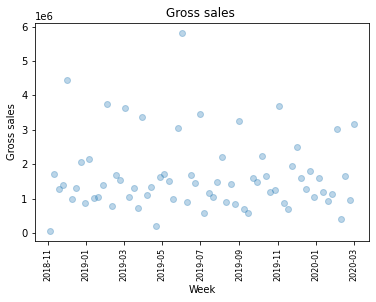

In [12]:
plt.scatter(weekly.Date , weekly.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("Gross sales")
plt.title("Gross sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

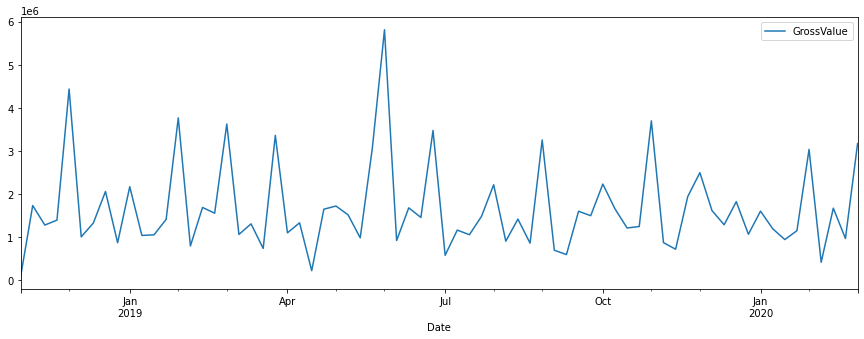

In [13]:
weekly.plot(kind = 'line', x = 'Date', y = 'GrossValue')
plt.show()

In [41]:
# remove z score > 3 
Sec_invoice_Agg = weekly[(np.abs(stats.zscore(weekly["GrossValue"])) < 3)]

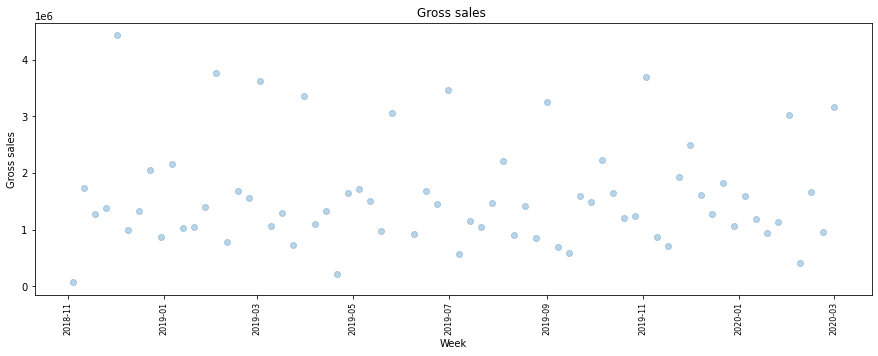

In [42]:
plt.scatter(Sec_invoice_Agg.Date , Sec_invoice_Agg.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("Gross sales")
plt.title("Gross sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

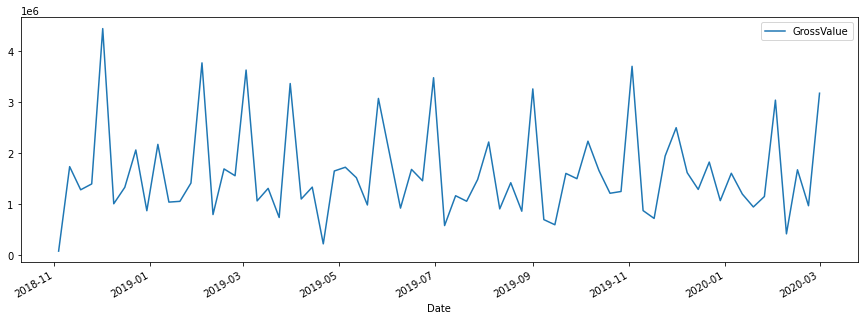

In [43]:
Sec_invoice_Agg.plot(kind = 'line', x = 'Date', y = 'GrossValue')
plt.show()

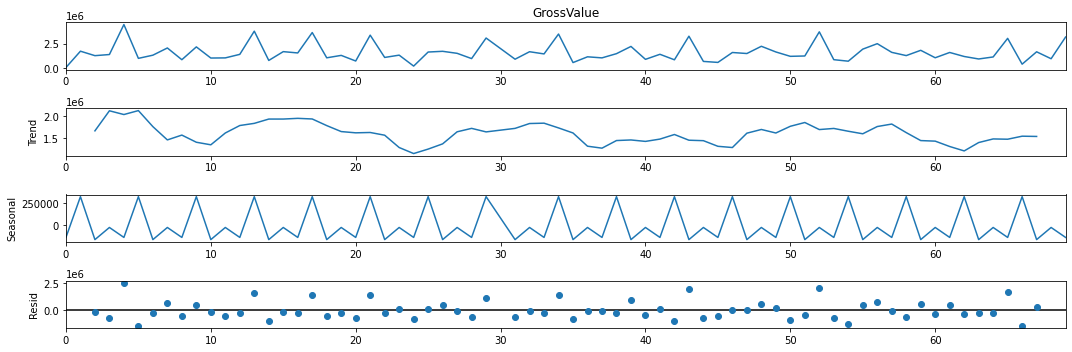

In [44]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =4)
decomposition.plot()
plt.show()

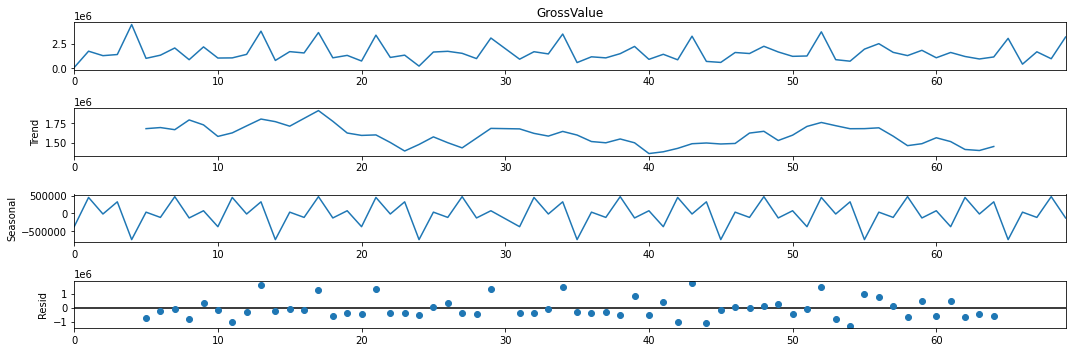

In [45]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =10)
decomposition.plot()
plt.show()

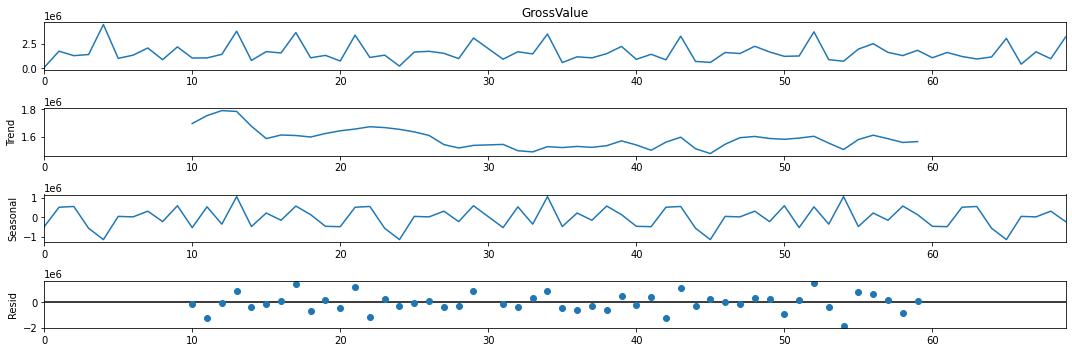

In [46]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =20)
decomposition.plot()
plt.show()

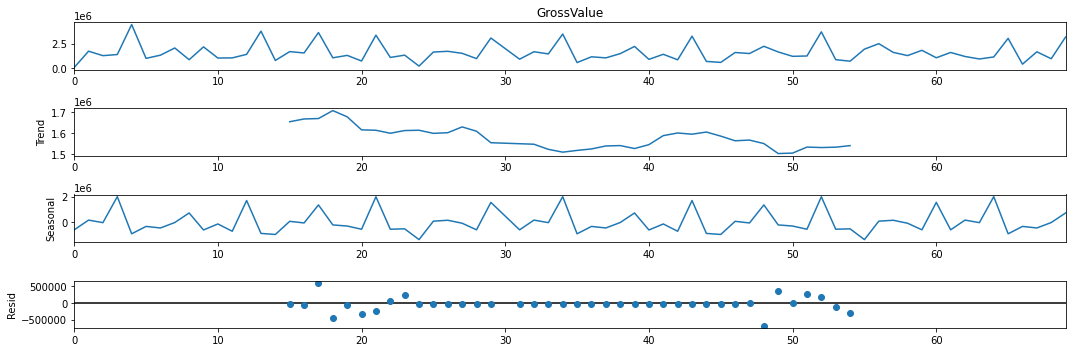

In [47]:
decomposition = seasonal_decompose(Sec_invoice_Agg['GrossValue'], period =30)
decomposition.plot()
plt.show()

In [48]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Sec_invoice_Agg['GrossValue'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -4.599395
p-value                         0.000130
#Lags Used                      7.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [51]:
#create Date Table
def create_date_table2(start='2018-11-04', end='2020-03-01'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    return df

In [52]:
date_table = create_date_table2()

In [53]:
date_table.head(12)

,Date
0,2018-11-04
1,2018-11-05
2,2018-11-06
3,2018-11-07
4,2018-11-08
5,2018-11-09
6,2018-11-10
7,2018-11-11
8,2018-11-12
9,2018-11-13


In [54]:
# keep every 7th row
date_table = date_table.iloc[::7, :]

In [55]:
date_table

,Date
0,2018-11-04
7,2018-11-11
14,2018-11-18
21,2018-11-25
28,2018-12-02
...,...
455,2020-02-02
462,2020-02-09
469,2020-02-16
476,2020-02-23


In [56]:
#left Join with Weekly date table
Sec_inv_mis = date_table.merge(Sec_invoice_Agg, on='Date', how='left')

In [57]:
Sec_inv_mis.head(10)

,Date,GrossValue
0,2018-11-04,71190.9
1,2018-11-11,1728491.5
2,2018-11-18,1274453.6
3,2018-11-25,1389318.8
4,2018-12-02,4435896.5
5,2018-12-09,1000285.0
6,2018-12-16,1322777.3
7,2018-12-23,2055084.0
8,2018-12-30,863742.0
9,2019-01-06,2165282.5


In [58]:
#fill missing value with mean
Sec_inv_mis.fillna({"GrossValue":Sec_inv_mis['GrossValue'].mean().round(1)}, inplace=True)

In [59]:
Sec_inv_grp = Sec_inv_mis.sort_index()
Sec_inv_grp.head(10)

,Date,GrossValue
0,2018-11-04,71190.9
1,2018-11-11,1728491.5
2,2018-11-18,1274453.6
3,2018-11-25,1389318.8
4,2018-12-02,4435896.5
5,2018-12-09,1000285.0
6,2018-12-16,1322777.3
7,2018-12-23,2055084.0
8,2018-12-30,863742.0
9,2019-01-06,2165282.5


In [60]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Sec_inv_grp.loc[Sec_inv_grp['Date'] <= "2019-11-30"]
train = train.set_index('Date')
test = Sec_inv_grp.loc[Sec_inv_grp['Date'] > "2019-11-30"]
test = test.set_index('Date')

In [61]:
from pmdarima import auto_arima
model = auto_arima(train.GrossValue, test='adf', trace=True, start_p=1,start_q=1 ,max_p=4,max_q=4 
                   ,suppress_warnings=True,stepwise=False,seasonal=False)
results = model.fit(train.GrossValue)
results.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1776.990, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1765.513, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1758.704, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1760.293, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1750.868, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1746.225, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1715.047, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1704.742, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1706.649, Time=0.10 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1707.318, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1734.581, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1714.206, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1709.817, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1730.048, Time=0.03 sec
 ARIMA(3,0,1)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -848.371
Date:                Sun, 17 Apr 2022   AIC                           1704.742
Time:                        20:05:37   BIC                           1712.844
Sample:                             0   HQIC                          1707.883
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5827.620      0.000       1.000       1.000
ma.L1         -1.5080      0.151    -10.014      0.000      -1.803      -1.213
ma.L2          0.5171      0.152      3.403      0.001       0.219       0.815
sigma2      8.016e+11   1.07e-13   7.46e+24      0.000    8.02e+11    8.02e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                15.84
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.10
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.09e+40. Standard errors may be unstable.
"""

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['GrossValue'],
                order=(1,0,2),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GrossValue   No. Observations:                   56
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -848.371
Date:                Sun, 17 Apr 2022   AIC                           1704.742
Time:                        20:05:42   BIC                           1712.844
Sample:                    11-04-2018   HQIC                          1707.883
                         - 11-24-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5827.620      0.000       1.000       1.000
ma.L1         -1.5080      0.151    -10.014      0.000      -1.803      -1.213
ma.L2          0.5171      0.152      3.403      0.001       0.219       0.815
sigma2      8.016e+11   1.07e-13   7.46e+24      0.000    8.02e+11    8.02e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                15.84
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.10
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.09e+40. Standard errors may be unstable.
"""

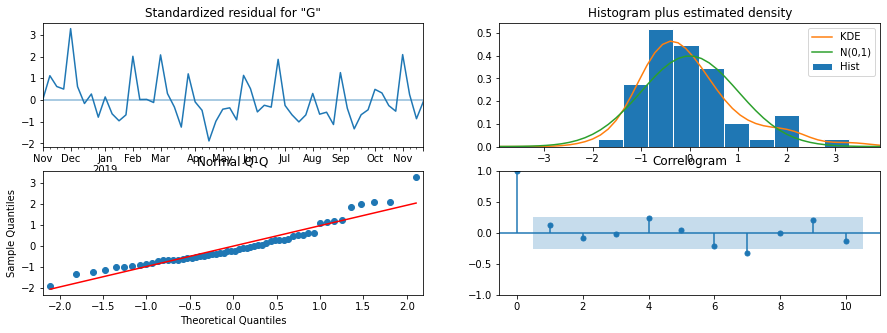

In [63]:
results.plot_diagnostics()
plt.show()

### Rolling Forecast ARIMA Model

In [64]:
X = Sec_inv_grp.GrossValue.values
data_Size = int(len(Sec_inv_grp.GrossValue.values))
train_size = int(len(train.GrossValue.values))


X_train, X_test = X[0:train_size], X[train_size:data_Size]
history = [x for x in X_train]
predictions = []

In [65]:
for t in range(len(test)):
    model = SARIMAX(history, order=(1,0,2),seasonal_order=(0,0,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parame

In [66]:
# get array data to DF with date index
Prd_Results = pd.DataFrame(data = predictions, columns = ['GrossValue'], index = test.index.copy())

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test, Prd_Results)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 708791.182813


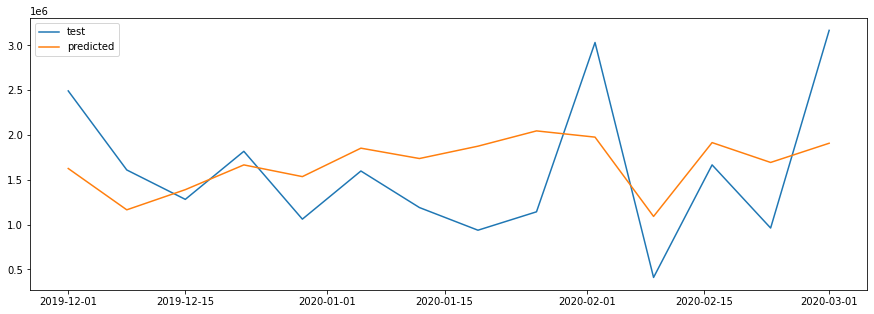

In [68]:
plt.plot(test)
plt.plot(Prd_Results)
plt.legend(['test', 'predicted'])

In [76]:
#Aggregate data into weekly sum
sample_price=Sec_invoice_All[['Date','UnitPrice']]
weekly_price=sample_price.drop_duplicates()

In [77]:
#get week start date time
weekly_price['week_start'] = weekly_price['Date'] - pd.offsets.Week(weekday=6)

<ipython-input-77-2c32a8b92fed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_price['week_start'] = weekly_price['Date'] - pd.offsets.Week(weekday=6)


In [78]:
#convert week start date time to date
weekly_price['week_start'] = pd.to_datetime(weekly_price['week_start']).dt.date

<ipython-input-78-70b2120873e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_price['week_start'] = pd.to_datetime(weekly_price['week_start']).dt.date


In [79]:
weekly_price=weekly_price[['week_start','UnitPrice']]
weekly_price = weekly_price.drop_duplicates()
weekly_price = weekly_price.sort_values(by="week_start")

In [80]:
weekly_price

,week_start,UnitPrice
3242,2018-10-28,216.7
8402,2018-10-28,238.7
83,2018-11-04,238.7
2033,2018-11-04,216.7
2036,2018-11-04,206.1
...,...,...
561558,2020-02-16,264.0
603501,2020-02-23,206.1
603499,2020-02-23,263.2
573675,2020-02-23,264.0
